First we will use the [example from scikit-learn](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html), then we will redo this example using Jacobian regularization

C:\Users\michael\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.0953e-19): result may not be accurate.
  overwrite_a=True).T


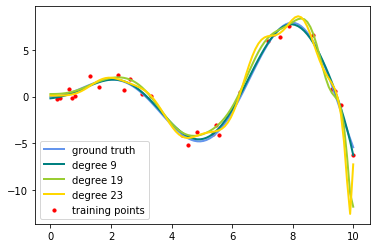

In [101]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline


def f(x):
    """ function to approximate by polynomial interpolation"""
    return x * np.sin(x)


# generate points used to plot
x_plot = np.linspace(0, 10, 100)

# generate points and keep a subset of them
x = np.linspace(0, 10, 100)
rng = np.random.RandomState(0)
rng.shuffle(x)
x = np.sort(x[:28])
y = f(x) + np.random.rand(x.shape[0]) *2 - 1

# create matrix versions of these arrays
X = x[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

colors = ['teal', 'yellowgreen', 'gold']
lw = 2
plt.plot(x_plot, f(x_plot), color='cornflowerblue', linewidth=lw,
         label="ground truth")
plt.scatter(x, y, color='red', s=10, marker='o', label="training points")

for count, degree in enumerate([9, 19, 23]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(X, y)
    y_plot = model.predict(X_plot)
    plt.plot(x_plot, y_plot, color=colors[count], linewidth=lw,
             label="degree %d" % degree)

plt.legend()

plt.show()

We see that for higher polynomial degrees we have a lot of overfitting. This is because Ridge regularization pushes all coefficients lower with the same force, whereas what we really want to accomplish is to make the function smoother, which means lowering the higher degree coefficients more, than the lower degree coefficients.

In [57]:
import tensorflow as tf
from keras.layers import BatchNormalization

Trying Degree  9
Epoch 0 Cost = 6.8305955
Epoch 33901 Cost = 1.430906
Epoch 67802 Cost = 1.0760585
Epoch 101703 Cost = 0.85417396
Epoch 135604 Cost = 0.7151881
Epoch 169505 Cost = 0.6278821
Epoch 203406 Cost = 0.57277733
Epoch 237307 Cost = 0.5377801
Epoch 271208 Cost = 0.51532036
Epoch 305109 Cost = 0.5006832
Epoch 339010 Cost = 0.49091402
Trying Degree  19
Epoch 0 Cost = 6.8305955
Epoch 33901 Cost = 0.6733419
Epoch 67802 Cost = 0.56668055
Epoch 101703 Cost = 0.49684212
Epoch 135604 Cost = 0.45054802
Epoch 169505 Cost = 0.41969103
Epoch 203406 Cost = 0.39896244
Epoch 237307 Cost = 0.3848807
Epoch 271208 Cost = 0.37516674
Epoch 305109 Cost = 0.36832634
Epoch 339010 Cost = 0.3633823
Trying Degree  23
Epoch 0 Cost = 6.8305955
Epoch 33901 Cost = 0.8771411
Epoch 67802 Cost = 0.6728597
Epoch 101703 Cost = 0.5478073
Epoch 135604 Cost = 0.4701919
Epoch 169505 Cost = 0.42197615
Epoch 203406 Cost = 0.3919746
Epoch 237307 Cost = 0.37326458
Epoch 271208 Cost = 0.3615461
Epoch 305109 Cost = 0.3541

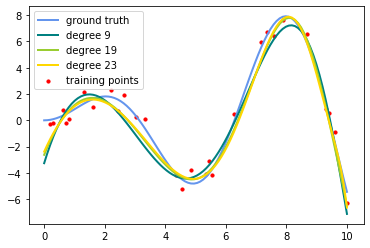

In [102]:
learning_rates = [0.1, 0.1, 0.05]
lmbda = 0.0
n_epochs = 339011

plt.plot(x_plot, f(x_plot), color='cornflowerblue', linewidth=lw,
         label="ground truth")
plt.scatter(x, y, color='red', s=10, marker='o', label="training points")    


for count, degree in enumerate([9, 19, 23]):
    print('Trying Degree ', degree)
    
    #Defining polynomial features, using scaler
    x_train = PolynomialFeatures(degree=degree).fit_transform(X)
    x_test = PolynomialFeatures(degree=degree).fit_transform(X_plot)
    scaler = StandardScaler().fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    
    #Defining the placeholders and variables
    input_x = tf.placeholder(dtype='float', shape=(None,degree+1))
    input_y = tf.placeholder(dtype='float', shape=(None,1))   
    coef = tf.Variable(initial_value=np.zeros((degree+1,1)), name="coef", dtype='float')
    
    prediction = input_x @ coef
    loss = (input_y - prediction) ** 2 / 2
    cost = tf.reduce_mean(loss)
    
    #optimizer = tf.train.AdamOptimizer(learning_rate=learning_rates[count])
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rates[count])
    
    training_op = optimizer.minimize(cost)    
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(n_epochs):
            if epoch % (n_epochs // 10) == 0:
                print("Epoch", epoch, "Cost =", cost.eval(feed_dict={input_x: x_train, input_y: y.reshape(-1,1) }))
            sess.run(training_op, feed_dict={input_x: x_train, input_y: y.reshape(-1,1) })
        
        y_plot = prediction.eval(feed_dict={input_x: x_test})
        #print(coef.eval().reshape(-1))
        
    plt.plot(x_plot, y_plot, color=colors[count], linewidth=lw,
             label="degree %d" % degree)

plt.legend()

plt.show()
